# **Harmonizing Gaze and Nature: Integrating Plant Signals and Eye Tracking Data for a Music Transcoding Compositional Process**


# 👁️🎼 **From Gaze, Image & Plant Data to Music** 🌱🎶  

## **🔬 Data-Driven Musical Composition: Analyzing Eye movements, Images & Nature**  

This notebook explores how **gaze tracking, image processing, and plant data** can be transformed into **musical elements** through structured analysis. The goal is to create a **data-driven composition** that reflects visual attention patterns and natural elements in music.  

### **✨ What Does This Notebook Do?**  
✅ **Processes gaze-tracking data** to analyze visual focus points  
✅ **Extracts features from images** to influence musical parameters  
✅ **Analyzes plant growth and environmental data** for musical inspiration  
✅ **Maps numerical values to musical elements** (pitch, rhythm, dynamics)  
✅ **Generates and exports music compositions** in **MusicXML and MIDI**  
✅ **Visualizes gaze patterns, image textures, and plant metrics**  

🎶

**1.Transcoding plant data into a music score**

1.1.
## 📚 Importing Libraries  
This section loads the necessary Python libraries for gaze analysis, image processing, plant data exploration, and music generation.


In [ ]:
!pip install MIDIUtil
!pip install music21
!apt-get install musescore
!apt-get install lilypond

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
musescore is already the newest version (2.3.2+dfsg4-15).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lilypond is already the newest version (2.22.1-2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


1.2.

## Music Transcoding of Plant Electrophysiology Data 🎻🍀

In [ ]:
from google.colab import drive
import pandas as pd
from music21 import stream, note, environment, midi
from IPython.display import Image
drive.mount('/content/drive', force_remount=True)

environment.set('lilypondPath', '/usr/bin/lilypond')
environment.set('musicxmlPath', '/usr/bin/musescore')

csv_files = [
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-1.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-2.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-3.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-4.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-5.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-6.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-7.csv',
    '/content/drive/MyDrive/8_plantes/CdRM-t0-bcc86b-8.csv'
]

all_mv_data = pd.concat([pd.read_csv(f)['mV'] for f in csv_files])
all_mv_data = pd.to_numeric(all_mv_data, errors='coerce').dropna()
global_min = all_mv_data.min()
global_max = all_mv_data.max()

piano_min = 21
piano_max = 108
fixed_velocity = 64
fixed_duration = 0.25

stretched_streams = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df['mV'] = pd.to_numeric(df['mV'], errors='coerce')
    df.dropna(subset=['mV'], inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)
    df.set_index('timestamp', inplace=True)
    df_resampled = df[['mV']].resample('5T').mean()  # Only resample the 'mV' column
    df_resampled.interpolate(method='linear', inplace=True)
    df_resampled.reset_index(inplace=True)

    plant_stream = stream.Part()
    previous_midi_value = None
    current_duration = 0

    for index, row in df_resampled.iterrows():
        midi_value = ((row['mV'] - global_min) / (global_max - global_min) * (piano_max - piano_min) + piano_min)
        midi_value = round(midi_value)  # Round to the nearest MIDI note value
        if midi_value == previous_midi_value:
            current_duration += fixed_duration
        else:
            if previous_midi_value is not None:
                n = note.Note()
                n.pitch.midi = previous_midi_value
                n.duration.quarterLength = current_duration
                n.volume.velocity = fixed_velocity
                plant_stream.append(n)
            previous_midi_value = midi_value
            current_duration = fixed_duration

    if previous_midi_value is not None:
        n = note.Note()
        n.pitch.midi = previous_midi_value
        n.duration.quarterLength = current_duration
        n.volume.velocity = fixed_velocity
        plant_stream.append(n)

    stretched_streams.append(plant_stream)

stretched_score = stream.Score()
for stretched_stream in stretched_streams:
    stretched_score.insert(0, stretched_stream)

midi_file_path = "/content/drive/MyDrive/8_plantes/transcoding_article.mid"
mf = midi.translate.music21ObjectToMidiFile(stretched_score)
mf.open(midi_file_path, 'wb')
mf.write()
mf.close()

print(f"MIDI exported to {midi_file_path}")

musicxml_file_path = "/content/drive/MyDrive/8_plantes/transcoding_article.xml"
stretched_score.write('musicxml', fp=musicxml_file_path)

print(f"MusicXML exported to {musicxml_file_path}")


Mounted at /content/drive
MIDI exported to /content/drive/MyDrive/8_plantes/transcoding_article.mid
MusicXML exported to /content/drive/MyDrive/8_plantes/transcoding_article.xml


1.3.
## Visualisation of the resulting MIDI file 🪄

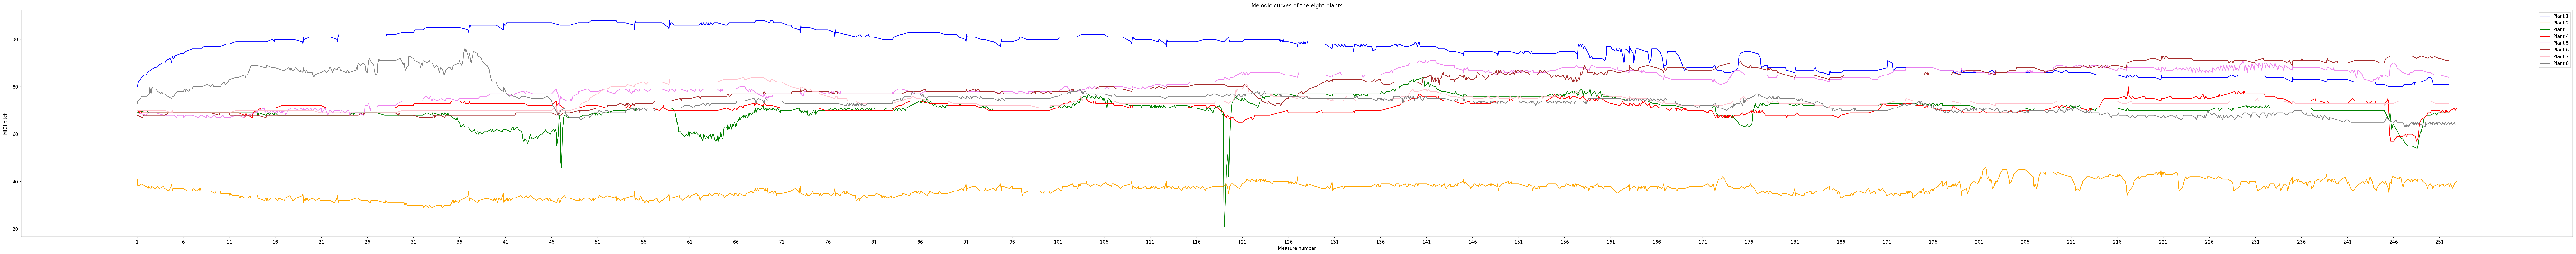

In [ ]:
from music21 import midi, stream
import matplotlib.pyplot as plt
import numpy as np

midi_path = '/content/drive/MyDrive/8_plantes/transcoding_article.mid'
mf = midi.MidiFile()
mf.open(midi_path)
mf.read()
mf.close()

midi_stream = midi.translate.midiFileToStream(mf)
fig, ax = plt.subplots(figsize=(80, 8))
colors = ['blue', 'orange', 'green', 'red', 'violet', 'brown', 'pink', 'grey']
beats_per_measure = 4
quarters_per_measure = beats_per_measure

min_measure = float('inf')
max_measure = 0

for idx, part in enumerate(midi_stream.parts):
    pitches = []
    measure_numbers = []

    for element in part.flatten().notesAndRests:
        if element.isNote or element.isChord:
            pitch = element.pitch.midi if element.isNote else sum(n.pitch.midi for n in element.notes) / len(element.notes)
            pitches.append(pitch)
            measure_number = element.offset / quarters_per_measure + 1
            measure_numbers.append(measure_number)
            min_measure = min(min_measure, measure_number)
            max_measure = max(max_measure, measure_number)

    ax.plot(measure_numbers, pitches, color=colors[idx], label=f'Plant {idx + 1}')

ax.set_ylabel('MIDI pitch')
ax.set_xlabel('Measure number')
ax.legend(loc='upper right')
plt.title('Melodic curves of the eight plants')

plt.xticks(np.arange(np.floor(min_measure), np.ceil(max_measure) + 1, 5))
plt.tight_layout()
plt.show()


## 👀 Processing Gaze Data  
We analyze eye-tracking data to extract visual attention points, which influence musical patterns.


2.
## **Designing a musical framework using gaze data**

2.1.
## Identification of fixation clusters and the initial viewing order 🔎

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'

gaze_data = pd.read_csv(file_path)
image = Image.open(image_path)

gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)

gaze_data['duration ms'] = gaze_data.groupby('RespondentNr')['timestamp ms'].diff().shift(-1)

last_fixations = gaze_data.groupby('RespondentNr')['timestamp ms'].tail(1).index
gaze_data.loc[last_fixations, 'duration ms'] = np.nan

gaze_data['Gaze x %'] *= image.width
gaze_data['Gaze y %'] *= image.height

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters

cluster_data = {i: {'durations': [], 'first_seen_times': []} for i in range(10)}

for i, group in gaze_data.groupby('RespondentNr'):
    for cluster in range(10):
        cluster_points = group[group['cluster'] == cluster]
        if not cluster_points.empty:
            cluster_data[cluster]['first_seen_times'].append(cluster_points.iloc[0]['timestamp ms'])
            cluster_data[cluster]['durations'].extend(cluster_points['duration ms'].dropna().tolist())

num_observers = gaze_data['RespondentNr'].nunique()
for cluster in cluster_data.keys():
    durations = cluster_data[cluster]['durations']
    if durations:
        cluster_data[cluster]['average_duration'] = np.nansum(durations) / num_observers
    else:
        cluster_data[cluster]['average_duration'] = np.nan
    first_seen_times = cluster_data[cluster]['first_seen_times']
    if first_seen_times:
        cluster_data[cluster]['first_seen'] = np.mean(first_seen_times)
    else:
        cluster_data[cluster]['first_seen'] = np.nan

sorted_clusters = sorted(cluster_data.keys(), key=lambda x: cluster_data[x]['first_seen'])

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
for i, cluster in enumerate(sorted_clusters):
    center = kmeans.cluster_centers_[cluster]
    radius = 50
    draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], outline='black')
    draw.text((center[0] - 20, center[1] - 20), str(i + 1), fill='red', font=font)

for i in range(len(sorted_clusters) - 1):
    start_cluster = kmeans.cluster_centers_[sorted_clusters[i]]
    end_cluster = kmeans.cluster_centers_[sorted_clusters[i + 1]]
    draw.line([start_cluster[0], start_cluster[1], end_cluster[0], end_cluster[1]], fill='black', width=2)
    direction = np.arctan2(end_cluster[1] - start_cluster[1], end_cluster[0] - start_cluster[0])
    draw.polygon([(end_cluster[0] - 10 * np.cos(direction + np.pi / 6), end_cluster[1] - 10 * np.sin(direction + np.pi / 6)),
                  (end_cluster[0], end_cluster[1]),
                  (end_cluster[0] - 10 * np.cos(direction - np.pi / 6), end_cluster[1] - 10 * np.sin(direction - np.pi / 6))], fill='black')

result_image_path = '/content/drive/MyDrive/Gaze_data_SS/result_image_with_arrows_and_numbers_transcoding_article.png'
image.save(result_image_path)

plt.figure(figsize=(image.width / 100, image.height / 100))
plt.imshow(image)
plt.axis('off')
plt.show()

for i, cluster in enumerate(sorted_clusters):
    print(f'Cluster {i + 1}: Average duration: {cluster_data[cluster]["average_duration"]:.2f} ms, First seen: {cluster_data[cluster]["first_seen"]} ms')


Output hidden; open in https://colab.research.google.com to view.

Results using previous versions of the libraries =

Cluster 1: Average duration: 9863.81 ms, First seen: 1647.4285714285713 ms

Cluster 2: Average duration: 9501.57 ms, First seen: 3066.4761904761904 ms

Cluster 3: Average duration: 6439.76 ms, First seen: 3994.4 ms

Cluster 4: Average duration: 4099.81 ms, First seen: 5994.761904761905 ms

Cluster 5: Average duration: 7297.76 ms, First seen: 5996.9473684210525 ms

Cluster 6: Average duration: 5766.67 ms, First seen: 6900.714285714285 ms

Cluster 7: Average duration: 3825.33 ms, First seen: 11755.904761904761 ms

Cluster 8: Average duration: 4443.14 ms, First seen: 12937.421052631578 ms

Cluster 9: Average duration: 3911.48 ms, First seen: 13862.78947368421 ms

Cluster 10: Average duration: 3789.05 ms, First seen: 15992.157894736842 ms

In [ ]:
# I will use the average durations obtained when using previous versions of libraries

average_durations = {
    1: 9863.81,
    2: 9501.57,
    3: 6439.76,
    4: 4099.81,
    5: 7297.76,
    6: 5766.67,
    7: 3825.33,
    8: 4443.14,
    9: 3911.48,
    10: 3789.05
}

total_compases = 252
total_average_duration = sum(average_durations.values())

percentage_per_cluster = {cluster: duration / total_average_duration for cluster, duration in average_durations.items()}
compases_por_cluster = {cluster: int(round(percentage * total_compases)) for cluster, percentage in percentage_per_cluster.items()}
diferencia = total_compases - sum(compases_por_cluster.values())
selected_cluster = min(compases_por_cluster, key=compases_por_cluster.get)
compases_por_cluster[selected_cluster] += diferencia

for cluster, compases in compases_por_cluster.items():
    print(f"Cluster {cluster}: {compases} compases")


Cluster 1: 42 compases
Cluster 2: 41 compases
Cluster 3: 28 compases
Cluster 4: 18 compases
Cluster 5: 31 compases
Cluster 6: 25 compases
Cluster 7: 15 compases
Cluster 8: 19 compases
Cluster 9: 17 compases
Cluster 10: 16 compases


Results using previous versions of the libraries =

Cluster 1: 42 compases

Cluster 2: 41 compases

Cluster 3: 28 compases

Cluster 4: 18 compases

Cluster 5: 31 compases

Cluster 6: 25 compases

Cluster 7: 15 compases

Cluster 8: 19 compases

Cluster 9: 17 compases

Cluster 10: 16 compases

## 🖼️ Extracting Features from Images  
This section analyzes image textures, color distributions, and object structures, transforming them into musical parameters.


2.2.
##Transcoding the color analysis of each fixation cluster into the musical harmony for each section of the score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1: Top colors: [(159, 183, 178), (168, 189, 188), (164, 187, 188), (156, 181, 187), (158, 182, 185), (227, 233, 216), (232, 236, 211), (238, 234, 227), (237, 236, 223), (160, 184, 189), (235, 235, 220), (160, 182, 188)]


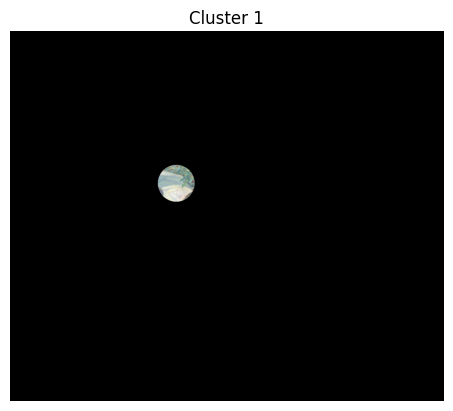

Cluster 2: Top colors: [(223, 230, 207), (222, 229, 209), (223, 230, 208), (217, 224, 202), (240, 241, 233), (237, 238, 229), (235, 237, 227), (232, 234, 225), (224, 232, 222), (223, 231, 219), (232, 236, 216), (229, 232, 215)]


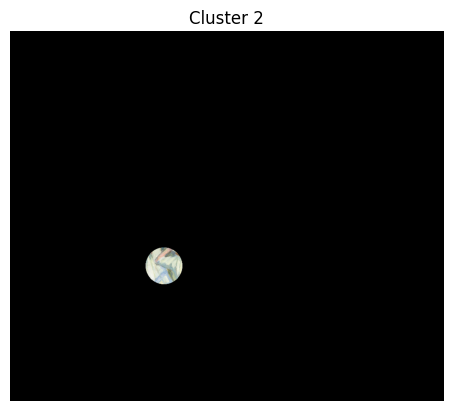

Cluster 3: Top colors: [(138, 148, 124), (110, 124, 105), (117, 135, 127), (136, 155, 126), (155, 153, 126), (155, 151, 126), (142, 146, 126), (109, 141, 126), (117, 137, 126), (132, 144, 125), (125, 141, 125), (121, 108, 93)]


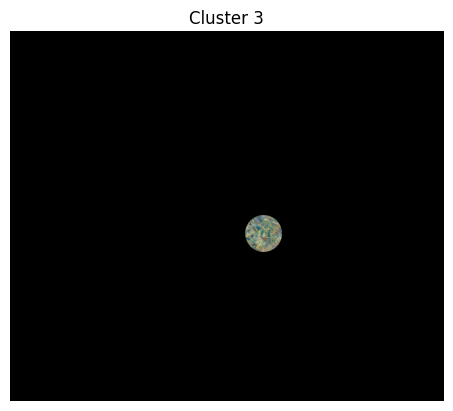

Cluster 4: Top colors: [(199, 197, 156), (192, 186, 150), (185, 177, 140), (148, 140, 126), (222, 218, 189), (234, 235, 219), (192, 193, 155), (184, 187, 154), (182, 184, 154), (189, 188, 153), (169, 176, 153), (204, 195, 152)]


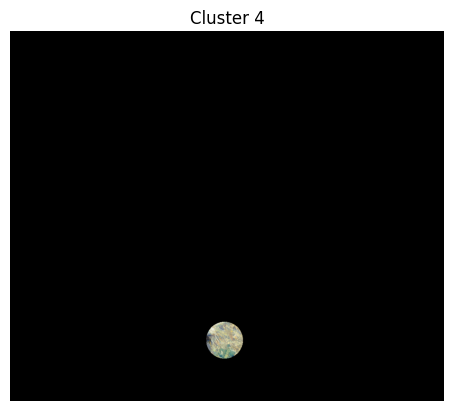

Cluster 5: Top colors: [(150, 179, 191), (133, 149, 159), (139, 172, 190), (128, 147, 158), (134, 167, 189), (147, 178, 188), (154, 161, 155), (159, 168, 153), (128, 143, 153), (160, 179, 184), (115, 121, 120), (141, 167, 183)]


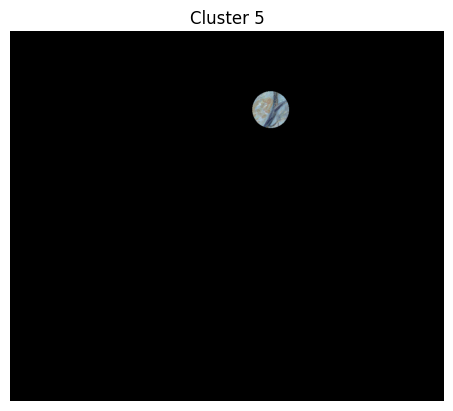

Cluster 6: Top colors: [(122, 135, 125), (168, 173, 124), (76, 113, 115), (135, 158, 145), (99, 139, 141), (81, 124, 141), (79, 109, 102), (139, 148, 127), (132, 145, 127), (114, 141, 127), (122, 136, 127), (150, 181, 158)]


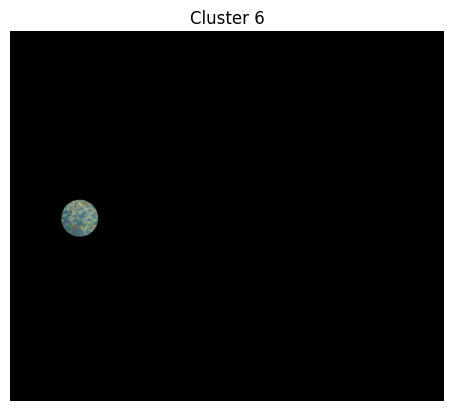

Cluster 7: Top colors: [(147, 175, 191), (160, 177, 189), (147, 172, 184), (148, 174, 191), (155, 178, 188), (152, 177, 193), (152, 176, 191), (153, 177, 190), (151, 175, 190), (149, 175, 189), (148, 174, 189), (153, 175, 187)]


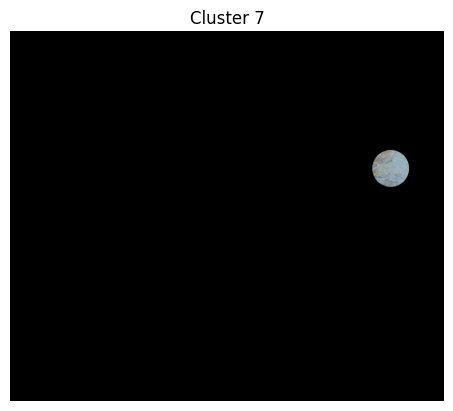

Cluster 8: Top colors: [(162, 160, 120), (152, 165, 140), (135, 165, 140), (154, 170, 139), (138, 161, 134), (139, 160, 133), (149, 163, 132), (144, 161, 130), (143, 159, 128), (162, 170, 127), (153, 166, 127), (148, 165, 127)]


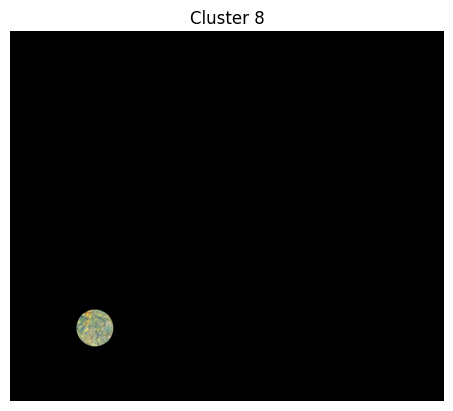

Cluster 9: Top colors: [(160, 152, 123), (151, 149, 120), (169, 151, 118), (176, 160, 117), (162, 150, 115), (159, 150, 115), (157, 143, 112), (163, 147, 111), (185, 174, 135), (191, 177, 134), (145, 162, 134), (154, 155, 133)]


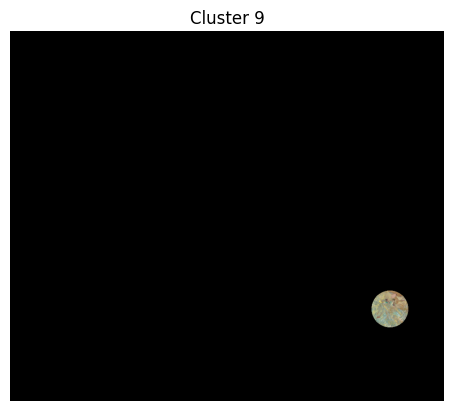

Cluster 10: Top colors: [(159, 191, 201), (160, 188, 196), (161, 188, 190), (148, 160, 150), (122, 147, 150), (118, 143, 147), (148, 159, 143), (139, 155, 143), (159, 188, 200), (156, 184, 192), (157, 183, 192), (161, 188, 191)]


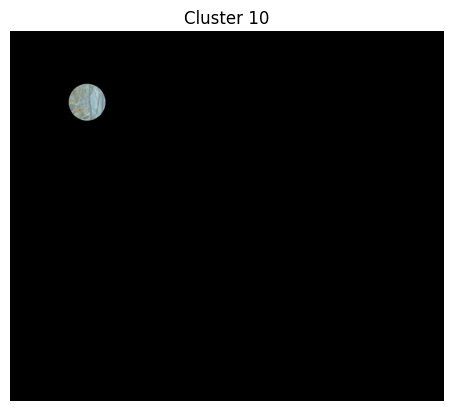

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2

def analyze_colors_inside_clusters(image_path, clusters_centers, cluster_radii):
    image_pil = Image.open(image_path).convert("RGB")
    for idx, (center, radius) in enumerate(zip(clusters_centers, cluster_radii)):
        center = tuple(map(int, center))
        radius = int(radius)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)
        mask_draw.ellipse([center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius], fill=255)
        masked_image = Image.composite(image_pil, Image.new("RGB", image_pil.size), mask)
        colors = masked_image.getcolors(maxcolors=masked_image.size[0]*masked_image.size[1])
        colors = sorted(colors, key=lambda x: x[0], reverse=True) if colors else []
        top_colors = [color for count, color in colors if color != (0, 0, 0) and color != (255, 255, 255)][:12]
        print(f"Cluster {idx + 1}: Top colors: {top_colors}")
        plt.imshow(masked_image)
        plt.axis('off')
        plt.title(f"Cluster {idx + 1}")
        plt.show()

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
gaze_data = pd.read_csv(file_path)
image = Image.open(image_path)
gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)
gaze_data['duration ms'] = gaze_data.groupby('RespondentNr')['timestamp ms'].diff().shift(-1)
last_fixations = gaze_data.groupby('RespondentNr')['timestamp ms'].tail(1).index
gaze_data.loc[last_fixations, 'duration ms'] = np.nan
gaze_data['Gaze x %'] *= image.width
gaze_data['Gaze y %'] *= image.height
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters
cluster_data = {i: {'durations': [], 'first_seen_times': []} for i in range(10)}
for i, group in gaze_data.groupby('RespondentNr'):
    for cluster in range(10):
        cluster_points = group[group['cluster'] == cluster]
        if not cluster_points.empty:
            cluster_data[cluster]['first_seen_times'].append(cluster_points.iloc[0]['timestamp ms'])
            cluster_data[cluster]['durations'].extend(cluster_points['duration ms'].dropna().tolist())

num_observers = gaze_data['RespondentNr'].nunique()
for cluster in cluster_data.keys():
    durations = cluster_data[cluster]['durations']
    cluster_data[cluster]['average_duration'] = np.nansum(durations) / num_observers if durations else np.nan
    first_seen_times = cluster_data[cluster]['first_seen_times']
    cluster_data[cluster]['first_seen'] = np.mean(first_seen_times) if first_seen_times else np.nan
sorted_clusters = sorted(cluster_data.keys(), key=lambda x: cluster_data[x]['first_seen'])

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
cluster_centers_for_color_analysis = []
cluster_radii_for_color_analysis = []
for i, cluster in enumerate(sorted_clusters):
    center = kmeans.cluster_centers_[cluster]
    radius = 50
    draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], outline='black')
    # Modificar la posición del texto para que no se superponga con la máscara
    draw.text((center[0] + radius + 5, center[1] - 10), str(i + 1), fill='red', font=font)
    cluster_centers_for_color_analysis.append(center)
    cluster_radii_for_color_analysis.append(radius)

marked_image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille_marked_article.png'
image.save(marked_image_path)
analyze_colors_inside_clusters(marked_image_path, cluster_centers_for_color_analysis, cluster_radii_for_color_analysis)


Results using previous versions of the libraries =

Cluster 1: Top colors: [(237, 236, 223), (159, 183, 178), (168, 189, 188), (164, 187, 188), (156, 181, 187), (158, 182, 185), (227, 233, 216), (231, 235, 212), (232, 236, 211), (238, 234, 227), (238, 233, 223), (235, 234, 222)]

Cluster 2: Top colors: [(223, 230, 207), (222, 229, 209), (232, 234, 225), (231, 234, 209), (223, 230, 208), (240, 241, 233), (237, 238, 229), (235, 237, 227), (233, 235, 225), (232, 234, 224), (224, 232, 222), (223, 231, 219)]

Cluster 3: Top colors: [(138, 148, 124), (110, 124, 105), (117, 135, 127), (136, 155, 126), (155, 153, 126), (155, 151, 126), (142, 146, 126), (109, 141, 126), (117, 137, 126), (132, 144, 125), (125, 141, 125), (121, 108, 93)]

Cluster 4: Top colors: [(164, 167, 147), (150, 179, 191), (133, 149, 159), (139, 172, 190), (128, 147, 158), (134, 167, 189), (147, 178, 188), (154, 161, 155), (159, 168, 153), (128, 143, 153), (160, 179, 184), (115, 121, 120)]

Cluster 5: Top colors: [(199, 197, 156), (192, 186, 150), (185, 177, 140), (148, 140, 126), (222, 218, 189), (192, 193, 155), (184, 187, 154), (182, 184, 154), (189, 188, 153), (169, 176, 153), (204, 195, 152), (179, 181, 152)]

Cluster 6: Top colors: [(122, 135, 125), (168, 173, 124), (76, 113, 115), (135, 158, 145), (99, 139, 141), (81, 124, 141), (79, 101, 103), (79, 109, 102), (126, 152, 127), (139, 148, 127), (132, 145, 127), (114, 141, 127)]

Cluster 7: Top colors: [(147, 175, 191), (148, 174, 191), (160, 177, 189), (147, 172, 184), (155, 178, 188), (152, 177, 193), (152, 176, 191), (153, 177, 190), (151, 175, 190), (149, 175, 189), (148, 174, 189), (153, 175, 187)]

Cluster 8: Top colors: [(162, 160, 120), (152, 165, 140), (135, 165, 140), (138, 161, 134), (139, 160, 133), (149, 163, 132), (144, 161, 130), (143, 159, 128), (162, 170, 127), (153, 166, 127), (148, 165, 127), (171, 162, 127)]

Cluster 9: Top colors: [(160, 152, 123), (151, 149, 120), (169, 151, 118), (176, 160, 117), (162, 150, 115), (159, 150, 115), (157, 143, 112), (163, 147, 111), (185, 174, 135), (191, 177, 134), (145, 162, 134), (154, 155, 133)]

Cluster 10: Top colors: [(159, 191, 201), (160, 188, 196), (161, 188, 190), (148, 160, 150), (122, 147, 150), (118, 143, 147), (148, 159, 143), (139, 155, 143), (159, 188, 200), (161, 189, 199), (158, 185, 197), (156, 184, 192)]


2.3.
## Visualization of the color palette for each fixation cluster 🔴🟡🔵

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


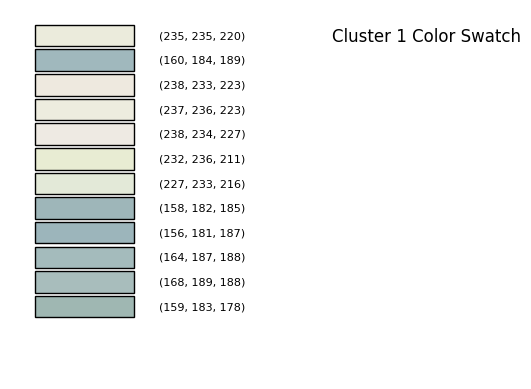

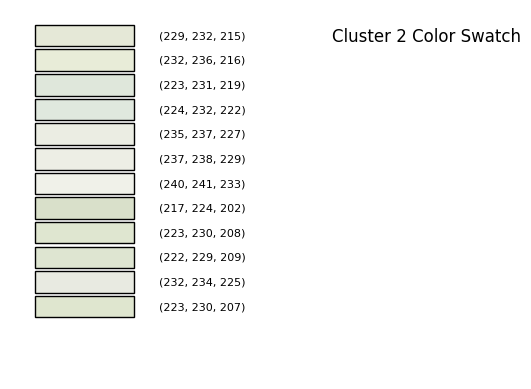

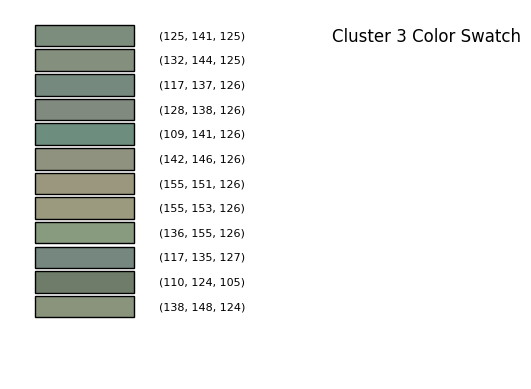

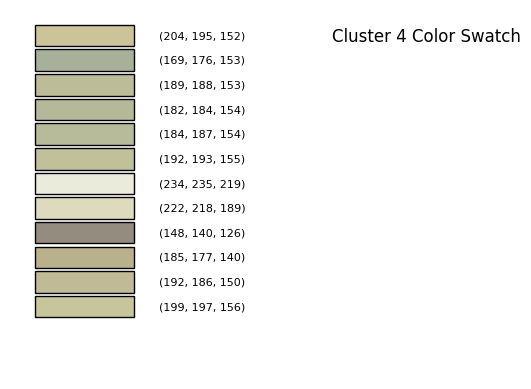

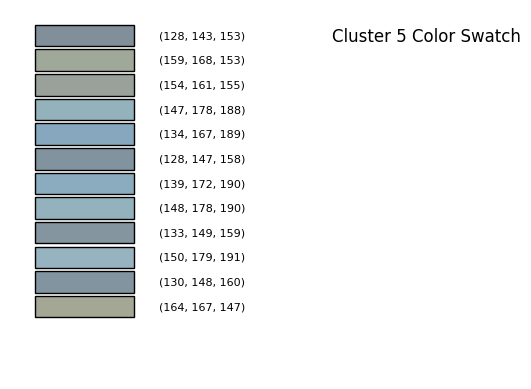

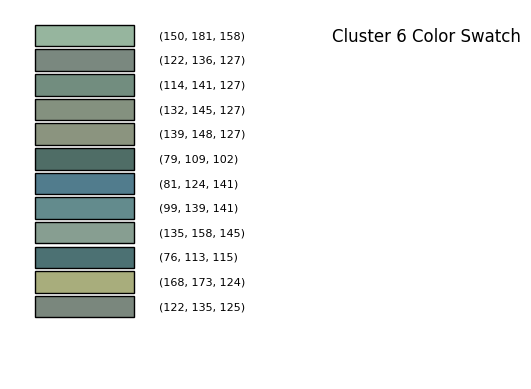

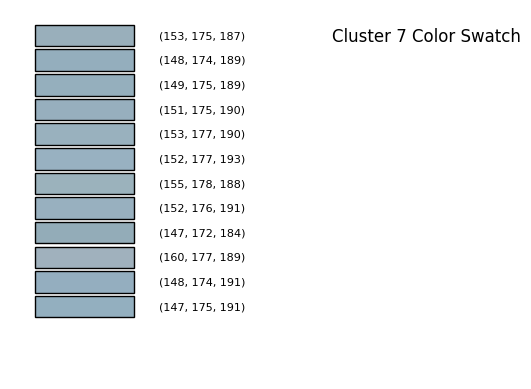

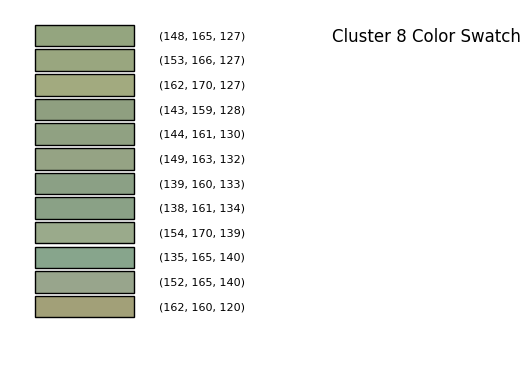

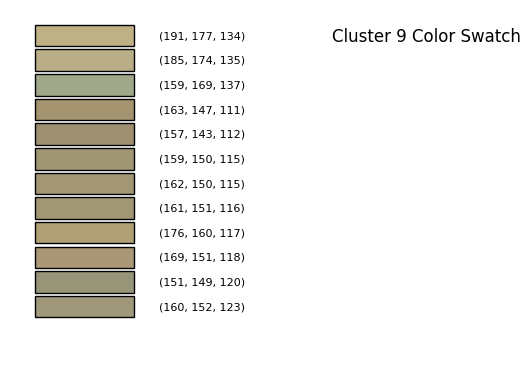

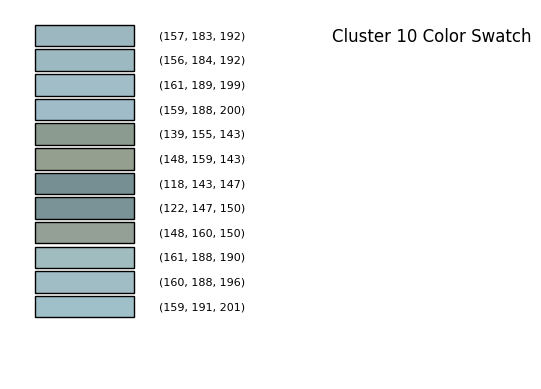

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def analyze_colors_inside_clusters(image_path, clusters_centers, cluster_radii):
    image_pil = Image.open(image_path).convert("RGB")
    for idx, (center, radius) in enumerate(zip(clusters_centers, cluster_radii)):
        center = tuple(map(int, center))
        radius = int(radius)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)
        mask_draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], fill=255)
        masked_image = Image.composite(image_pil, Image.new("RGB", image_pil.size), mask)
        colors = masked_image.getcolors(maxcolors=masked_image.size[0] * masked_image.size[1])
        colors = sorted(colors, key=lambda x: x[0], reverse=True) if colors else []
        top_colors = [color for count, color in colors if color != (0, 0, 0) and color != (255, 255, 255)][:12]

        fig, ax = plt.subplots()
        ax.axis('off')

        vertical_start = 0.15
        vertical_start = 0.2
        for i, color in enumerate(top_colors):
            normalized_color = tuple([c/255.0 for c in color])
            rect = Rectangle((0.05, vertical_start + i * 0.08), 0.2, 0.07, linewidth=1, edgecolor='black', facecolor=normalized_color)
            ax.add_patch(rect)
            ax.text(0.3, vertical_start + i * 0.08 + 0.035, f"{color}", fontsize=8, verticalalignment='center')

        ax.set_ylim(0, 1.2)
        ax.text(0.65, 0.95, f"Cluster {idx + 1} Color Swatch", fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left')
        plt.show()

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
gaze_data = pd.read_csv(file_path)
image = Image.open(image_path)
gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)
gaze_data['duration ms'] = gaze_data.groupby('RespondentNr')['timestamp ms'].diff().shift(-1)
last_fixations = gaze_data.groupby('RespondentNr')['timestamp ms'].tail(1).index
gaze_data.loc[last_fixations, 'duration ms'] = np.nan
gaze_data['Gaze x %'] *= image.width
gaze_data['Gaze y %'] *= image.height
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters
cluster_data = {i: {'durations': [], 'first_seen_times': []} for i in range(10)}
for i, group in gaze_data.groupby('RespondentNr'):
    for cluster in range(10):
        cluster_points = group[group['cluster'] == cluster]
        if not cluster_points.empty:
            cluster_data[cluster]['first_seen_times'].append(cluster_points.iloc[0]['timestamp ms'])
            cluster_data[cluster]['durations'].extend(cluster_points['duration ms'].dropna().tolist())

num_observers = gaze_data['RespondentNr'].nunique()
for cluster in cluster_data.keys():
    durations = cluster_data[cluster]['durations']
    cluster_data[cluster]['average_duration'] = np.nansum(durations) / num_observers if durations else np.nan
    first_seen_times = cluster_data[cluster]['first_seen_times']
    cluster_data[cluster]['first_seen'] = np.mean(first_seen_times) if first_seen_times else np.nan
sorted_clusters = sorted(cluster_data.keys(), key=lambda x: cluster_data[x]['first_seen'])

sorted_cluster_centers = [kmeans.cluster_centers_[i] for i in sorted_clusters]
sorted_radii = [50] * len(sorted_cluster_centers)  # Example radius for each sorted cluster

marked_image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille_marked_article.png'
image.save(marked_image_path)

analyze_colors_inside_clusters(marked_image_path, sorted_cluster_centers, sorted_radii)



2.4.
##Transforming each color palette into the musical scale for each section of the score. 📃

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
import colorsys

note_names_full = [
    'A0', 'A#0', 'B0', 'C1', 'C#1', 'D1', 'D#1', 'E1', 'F1', 'F#1', 'G1', 'G#1',
    'A1', 'A#1', 'B1', 'C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2',
    'A2', 'A#2', 'B2', 'C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3',
    'A3', 'A#3', 'B3', 'C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4',
    'A4', 'A#4', 'B4', 'C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5',
    'A5', 'A#5', 'B5', 'C6', 'C#6', 'D6', 'D#6', 'E6', 'F6', 'F#6', 'G6', 'G#6',
    'A6', 'A#6', 'B6', 'C7', 'C#7', 'D7', 'D#7', 'E7', 'F7', 'F#7', 'G7', 'G#7',
    'A7', 'A#7', 'B7', 'C8'
][:88]

def rgb_to_piano_note_hue_with_cents(rgb):
    """Converts an RGB color to a piano note and cents based on the hue."""
    scaled_rgb = [x / 255.0 for x in rgb]
    hue, _, _ = colorsys.rgb_to_hsv(*scaled_rgb)
    total_degrees = 360
    degrees_per_note = total_degrees / 88
    hue_degrees = hue * total_degrees
    note_index = int(hue_degrees / degrees_per_note) % 88
    note = note_names_full[note_index]
    note_position_in_degrees = note_index * degrees_per_note
    cents = ((hue_degrees - note_position_in_degrees) / degrees_per_note) * 100
    if cents >= 50:
        cents -= 100
        note_index = (note_index + 1) % 88
        note = note_names_full[note_index]
    return note, cents

def analyze_colors_and_map_notes(image_path, clusters_centers, cluster_radii):
    image_pil = Image.open(image_path).convert("RGB")
    for idx, (center, radius) in enumerate(zip(clusters_centers, cluster_radii)):
        center = tuple(map(int, center))
        radius = int(radius)
        mask = Image.new("L", image_pil.size, 0)
        mask_draw = ImageDraw.Draw(mask)
        mask_draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], fill=255)
        masked_image = Image.composite(image_pil, Image.new("RGB", image_pil.size), mask)
        colors = masked_image.getcolors(maxcolors=masked_image.size[0] * masked_image.size[1])
        colors = sorted(colors, key=lambda x: x[0], reverse=True) if colors else []
        top_colors = [color for count, color in colors if color != (0, 0, 0) and color != (255, 255, 255)][:12]

        # Map colors to notes
        for color in top_colors:
            note, cents = rgb_to_piano_note_hue_with_cents(color)
            print(f"Cluster {idx + 1}, Color {color}: Note: {note}, Cents: {cents:+.2f}")

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
gaze_data = pd.read_csv(file_path)
image = Image.open(image_path)
gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)
gaze_data['duration ms'] = gaze_data.groupby('RespondentNr')['timestamp ms'].diff().shift(-1)
last_fixations = gaze_data.groupby('RespondentNr')['timestamp ms'].tail(1).index
gaze_data.loc[last_fixations, 'duration ms'] = np.nan
gaze_data['Gaze x %'] *= image.width
gaze_data['Gaze y %'] *= image.height
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters
sorted_clusters = sorted(range(10), key=lambda i: np.mean(gaze_data[gaze_data['cluster'] == i]['timestamp ms']))
sorted_cluster_centers = [kmeans.cluster_centers_[i] for i in sorted_clusters]
sorted_radii = [50] * len(sorted_cluster_centers)  # Example radius for each sorted cluster
analyze_colors_and_map_notes(image_path, sorted_cluster_centers, sorted_radii)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 1, Color (159, 183, 178): Note: D4, Cents: -5.56
Cluster 1, Color (168, 189, 188): Note: E4, Cents: +30.16
Cluster 1, Color (164, 187, 188): Note: F#4, Cents: -38.89
Cluster 1, Color (156, 181, 187): Note: G#4, Cents: -16.13
Cluster 1, Color (158, 182, 185): Note: G4, Cents: -37.04
Cluster 1, Color (227, 233, 216): Note: F2, Cents: -15.69
Cluster 1, Color (232, 236, 211): Note: D2, Cents: +1.33
Cluster 1, Color (238, 234, 227): Note: F#1, Cents: +33.33
Cluster 1, Color (237, 236, 223): Note: B1, Cents: -38.10
Cluster 1, Color (238, 233, 223): Note: G1, Cents: -22.22
Cluster 1, Color (160, 184, 189): Note: G#4, Cents: -47.13
Cluster 1, Color (235, 235, 220): Note: C2, Cents: -33.33
Cluster 2, Color (223, 230, 207): Note: E2, Cents: +13.04
Cluster 2, Color (232, 234, 225): Note: D#2, Cents: -7.41
Cluster 2, Color (222, 229, 209): Note: F2, Cents: -20.00
Cluster 2, Color (223, 230, 208): Note: E2, Cents: +33.33
Cluster 2, Color (217, 224, 202): Note: E2, Cents: +33.33
Cluster 2, C

Results obtained with previous versions of the libraries =

Cluster 1, Color (237, 236, 223): Note: B1, Cents: -38.10

Cluster 1, Color (159, 183, 178): Note: D4, Cents: -5.56

Cluster 1, Color (168, 189, 188): Note: E4, Cents: +30.16

Cluster 1, Color (164, 187, 188): Note: F#4, Cents: -38.89

Cluster 1, Color (235, 233, 219): Note: A#1, Cents: -16.67

Cluster 1, Color (156, 181, 187): Note: G#4, Cents: -16.13

Cluster 1, Color (158, 182, 185): Note: G4, Cents: -37.04

Cluster 1, Color (227, 233, 216): Note: F2, Cents: -15.69

Cluster 1, Color (231, 235, 212): Note: D2, Cents: +21.74

Cluster 1, Color (232, 236, 211): Note: D2, Cents: +1.33

Cluster 1, Color (238, 234, 227): Note: F#1, Cents: +33.33

Cluster 1, Color (238, 233, 223): Note: G1, Cents: -22.22

Cluster 2, Color (223, 230, 207): Note: E2, Cents: +13.04

Cluster 2, Color (231, 235, 210): Note: D2, Cents: +1.33

Cluster 2, Color (222, 229, 209): Note: F2, Cents: -20.00

Cluster 2, Color (232, 234, 225): Note: D#2, Cents: -7.41

Cluster 2, Color (231, 234, 209): Note: C#2, Cents: +42.67

Cluster 2, Color (223, 230, 208): Note: E2, Cents: +33.33

Cluster 2, Color (240, 241, 233): Note: C#2, Cents: +50.00

Cluster 2, Color (237, 238, 229): Note: C#2, Cents: +29.63

Cluster 2, Color (235, 237, 227): Note: D#2, Cents: -40.00


Cluster 2, Color (235, 236, 225): Note: C#2, Cents: +0.00

Cluster 2, Color (233, 235, 225): Note: D#2, Cents: -40.00

Cluster 2, Color (232, 234, 224): Note: D#2, Cents: -40.00

Cluster 3, Color (138, 148, 124): Note: F#2, Cents: -22.22

Cluster 3, Color (110, 124, 105): Note: A#2, Cents: +47.37

Cluster 3, Color (117, 135, 127): Note: A#3, Cents: +48.15

Cluster 3, Color (136, 155, 126): Note: A2, Cents: +27.59

Cluster 3, Color (155, 153, 126): Note: B1, Cents: -34.48

Cluster 3, Color (155, 151, 126): Note: A#1, Cents: -35.63

Cluster 3, Color (142, 146, 126): Note: D#2, Cents: -40.00

Cluster 3, Color (109, 141, 126): Note: A#3, Cents: +12.50

Cluster 3, Color (128, 138, 126): Note: C3, Cents: -11.11

Cluster 3, Color (117, 137, 126): Note: A3, Cents: -6.67

Cluster 3, Color (132, 144, 125): Note: A2, Cents: -7.02

Cluster 3, Color (125, 141, 125): Note: D3, Cents: +33.33

Cluster 4, Color (160, 152, 123): Note: G#1, Cents: +49.55

Cluster 4, Color (151, 149, 120): Note: B1, Cents: -27.96

Cluster 4, Color (169, 151, 118): Note: F#1, Cents: +49.02

Cluster 4, Color (176, 160, 117): Note: G#1, Cents: -31.07

Cluster 4, Color (162, 150, 115): Note: G#1, Cents: -7.80

Cluster 4, Color (159, 150, 115): Note: A1, Cents: -33.33

Cluster 4, Color (157, 143, 112): Note: G1, Cents: +10.37

Cluster 4, Color (163, 147, 111): Note: G1, Cents: +15.38

Cluster 4, Color (185, 174, 135): Note: G#1, Cents: +44.00

Cluster 4, Color (191, 177, 134): Note: G#1, Cents: +6.43

Cluster 4, Color (145, 162, 134): Note: A2, Cents: -42.86

Cluster 4, Color (154, 155, 133): Note: C2, Cents: +33.33

Cluster 5, Color (164, 167, 147): Note: D2, Cents: -13.33

Cluster 5, Color (150, 179, 191): Note: A4, Cents: +29.27

Cluster 5, Color (133, 149, 159): Note: B4, Cents: -35.90

Cluster 5, Color (148, 178, 190): Note: A4, Cents: +19.05

Cluster 5, Color (139, 172, 190): Note: A#4, Cents: +17.65

Cluster 5, Color (128, 147, 158): Note: A#4, Cents: +37.78

Cluster 5, Color (134, 167, 189): Note: B4, Cents: -13.33

Cluster 5, Color (147, 178, 188): Note: A4, Cents: -42.28

Cluster 5, Color (154, 161, 155): Note: E3, Cents: +42.86

Cluster 5, Color (159, 168, 153): Note: G#2, Cents: +46.67

Cluster 5, Color (128, 143, 153): Note: B4, Cents: -13.33

Cluster 5, Color (160, 179, 184): Note: G#4, Cents: +5.56

Cluster 6, Color (162, 160, 120): Note: B1, Cents: -3.17

Cluster 6, Color (152, 165, 140): Note: G2, Cents: +29.33

Cluster 6, Color (135, 165, 140): Note: F3, Cents: -22.22

Cluster 6, Color (154, 170, 139): Note: G2, Cents: +23.66

Cluster 6, Color (138, 161, 134): Note: C3, Cents: +16.05

Cluster 6, Color (139, 160, 133): Note: B2, Cents: +7.41

Cluster 6, Color (149, 163, 132): Note: F#2, Cents: +29.03

Cluster 6, Color (144, 161, 130): Note: G#2, Cents: -29.03

Cluster 6, Color (143, 159, 128): Note: G2, Cents: +23.66

Cluster 6, Color (162, 170, 127): Note: D2, Cents: +39.53

Cluster 6, Color (153, 166, 127): Note: F2, Cents: -44.44

Cluster 6, Color (148, 165, 127): Note: F#2, Cents: +22.81

Cluster 7, Color (147, 175, 191): Note: A#4, Cents: +33.33

Cluster 7, Color (148, 174, 191): Note: B4, Cents: -20.16

Cluster 7, Color (160, 177, 189): Note: B4, Cents: +6.90

Cluster 7, Color (147, 172, 184): Note: A#4, Cents: -24.32

Cluster 7, Color (155, 178, 188): Note: A4, Cents: +44.44

Cluster 7, Color (152, 177, 193): Note: B4, Cents: -27.64

Cluster 7, Color (152, 176, 191): Note: B4, Cents: -35.90

Cluster 7, Color (148, 176, 191): Note: A#4, Cents: +11.63

Cluster 7, Color (153, 177, 190): Note: A#4, Cents: +15.32

Cluster 7, Color (151, 175, 190): Note: B4, Cents: -35.90

Cluster 7, Color (149, 175, 189): Note: A#4, Cents: +13.33

Cluster 7, Color (148, 174, 189): Note: A#4, Cents: +36.59

Cluster 8, Color (199, 197, 156): Note: B1, Cents: -1.55

Cluster 8, Color (192, 186, 150): Note: A#1, Cents: -42.86

Cluster 8, Color (185, 177, 140): Note: A1, Cents: +5.93

Cluster 8, Color (148, 140, 126): Note: F#1, Cents: +33.33

Cluster 8, Color (222, 218, 189): Note: A#1, Cents: -11.11

Cluster 8, Color (192, 193, 155): Note: C2, Cents: +5.26

Cluster 8, Color (184, 187, 154): Note: C#2, Cents: -0.00

Cluster 8, Color (182, 184, 154): Note: C#2, Cents: -35.56

Cluster 8, Color (189, 188, 153): Note: B1, Cents: +25.93

Cluster 8, Color (169, 176, 153): Note: E2, Cents: +13.04

Cluster 8, Color (204, 195, 152): Note: A1, Cents: +12.82

Cluster 8, Color (179, 181, 152): Note: C#2, Cents: -32.18

Cluster 9, Color (159, 191, 201): Note: G#4, Cents: +49.21

Cluster 9, Color (160, 188, 196): Note: G#4, Cents: +25.93

Cluster 9, Color (161, 188, 190): Note: F#4, Cents: +1.15

Cluster 9, Color (148, 160, 150): Note: F3, Cents: -22.22

Cluster 9, Color (122, 147, 150): Note: G4, Cents: -42.86

Cluster 9, Color (118, 143, 147): Note: G4, Cents: +2.30

Cluster 9, Color (148, 159, 143): Note: A#2, Cents: -25.00

Cluster 9, Color (139, 155, 143): Note: F#3, Cents: +0.00

Cluster 9, Color (159, 188, 200): Note: A4, Cents: +29.27

Cluster 9, Color (161, 189, 199): Note: A4, Cents: -14.04

Cluster 9, Color (158, 185, 197): Note: A#4, Cents: -48.72

Cluster 9, Color (156, 184, 192): Note: G#4, Cents: +25.93

Cluster 10, Color (122, 135, 125): Note: F#3, Cents: -28.21

Cluster 10, Color (168, 173, 124): Note: C#2, Cents: +16.33

Cluster 10, Color (76, 113, 115): Note: F#4, Cents: -24.79

Cluster 10, Color (135, 158, 145): Note: A3, Cents: -28.99

Cluster 10, Color (99, 139, 141): Note: F#4, Cents: -30.16

Cluster 10, Color (81, 124, 141): Note: A4, Cents: +15.56

Cluster 10, Color (79, 101, 103): Note: F#4, Cents: +22.22

Cluster 10, Color (79, 109, 102): Note: D4, Cents: -42.22

Cluster 10, Color (126, 152, 127): Note: D#3, Cents: -10.26

Cluster 10, Color (139, 148, 127): Note: F#2, Cents: -4.76

Cluster 10, Color (132, 145, 127): Note: A#2, Cents: +25.93

Cluster 10, Color (114, 141, 127): Note: A3, Cents: +39.51

2.4.
## Converting depth map data into velocities and dynamics 📈

In [ ]:

!rm -rf /content/MiDaS
!git clone https://github.com/intel-isl/MiDaS.git

!mkdir -p /content/MiDaS/weights /content/MiDaS/input /content/depth

!pip install torch==2.0.1 torchvision==0.15.2 timm==0.6.12 imutils==0.5.4 einops==0.6.0

!gdown https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_beit_large_512.pt -O /content/MiDaS/weights/dpt_beit_large_512.pt

!cp /content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png /content/MiDaS/input/

%cd /content/MiDaS/
!python run.py --model_type dpt_beit_large_512 --input_path /content/MiDaS/input/Sunny_September_grande_taille.png --output_path /content/depth --square --grayscale

%cd /content/


Cloning into 'MiDaS'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 622 (delta 183), reused 139 (delta 137), pack-reused 375 (from 1)
Receiving objects: 100% (622/622), 3.44 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (246/246), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 888.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

Downloading...
From: https://github.com/isl-org/MiDaS/releases/download/v3_1/dpt_beit_large_512.pt
To: /content/MiDaS/weights/dpt_beit_large_512.pt
100% 1.58G/1.58G [00:09<00:00, 164MB/s]
/content/MiDaS
Initialize
Device: cpu
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Traceback (most recent call last):
  File "/content/MiDaS/run.py", line 276, in <module>
    run(args.input_path, args.output_path, args.model_weights, args.model_type, args.optimize, args.side, args.height,
  File "/content/MiDaS/run.py", line 126, in run
    model, transform, net_w, net_h = load_model(device, model_path, model_type, optimize, height, square)
  File "/content/MiDaS/midas/model_loader.py", line 50, in load_model
    model = DPTDepthModel(
  

Using cache found in /root/.cache/torch/hub/isl-org_ZoeDepth_main


img_size [384, 512]


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt


Downloading: "https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt" to /root/.cache/torch/hub/checkpoints/ZoeD_M12_N.pt
100%|██████████| 1.34G/1.34G [00:10<00:00, 132MB/s]


Loaded successfully
Depth map saved to /content/drive/MyDrive/Gaze_data_SS/Sunny_September_depth.png


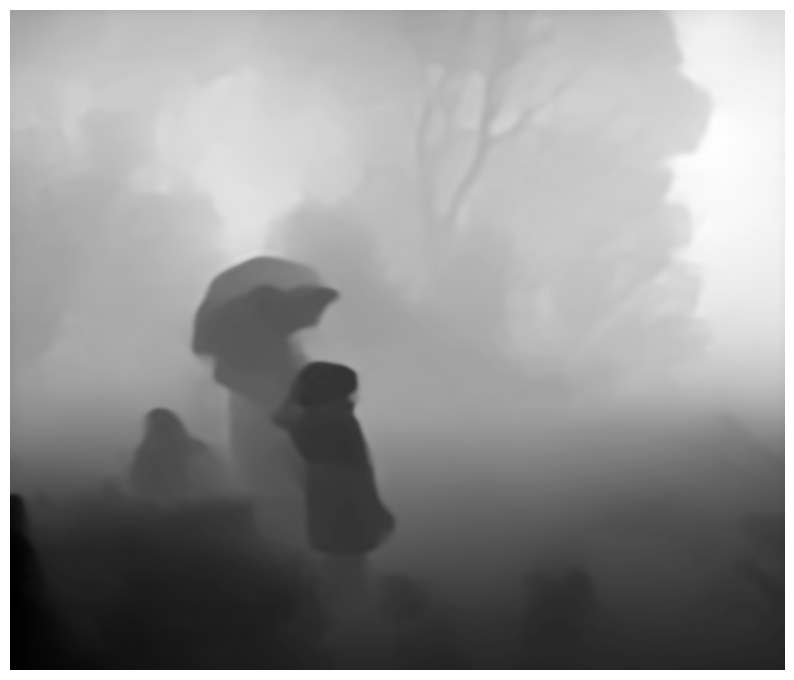

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive

image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
zoe = torch.hub.load('isl-org/ZoeDepth', 'ZoeD_N', pretrained=True)
zoe = zoe.to('cpu')

def load_and_prepare_image(image_path):
    img = Image.open(image_path).convert('RGB')
    return img

def generate_depth_map(model, img):
    depth = model.infer_pil(img)
    return depth

img = load_and_prepare_image(image_path)
depth_map = generate_depth_map(zoe, img)
depth_map_np = np.array(depth_map)
depth_map_normalized = 255 * (depth_map_np - np.min(depth_map_np)) / (np.max(depth_map_np) - np.min(depth_map_np))
depth_image = Image.fromarray(depth_map_normalized.astype(np.uint8))


output_path = os.path.join(os.path.dirname(image_path), 'Sunny_September_depth.png')
depth_image.save(output_path)
print(f"Depth map saved to {output_path}")

plt.figure(figsize=(10, 10))
plt.imshow(depth_image, cmap='gray')
plt.axis('off')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
depth_map_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_depth.png'

gaze_data = pd.read_csv(file_path)
original_image = Image.open(image_path)
depth_map_image = Image.open(depth_map_path)
depth_map_array = np.array(depth_map_image)

min_depth_overall = np.nanmin(depth_map_array)
max_depth_overall = np.nanmax(depth_map_array)

gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)
gaze_data['duration ms'] = gaze_data.groupby('RespondentNr')['timestamp ms'].diff().shift(-1)
last_fixations = gaze_data.groupby('RespondentNr')['timestamp ms'].tail(1).index
gaze_data.loc[last_fixations, 'duration ms'] = np.nan
gaze_data['Gaze x %'] = (gaze_data['Gaze x %'] * original_image.width).astype(int)
gaze_data['Gaze y %'] = (gaze_data['Gaze y %'] * original_image.height).astype(int)

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters

def calculate_depth_range(depth_map, center, radius):
    x, y = center
    x_min, x_max = max(0, x - radius), min(depth_map.shape[1], x + radius)
    y_min, y_max = max(0, y - radius), min(depth_map.shape[0], y + radius)
    depth_slice = depth_map[y_min:y_max, x_min:x_max]
    min_depth = np.nanmin(depth_slice)
    max_depth = np.nanmax(depth_slice)
    return min_depth, max_depth

def depth_to_velocity(depth, min_depth, max_depth):
    if np.isnan(depth):
        return 0
    return int(1 + 126 * ((max_depth - depth) / (max_depth - min_depth)))

def assign_dynamics(velocity):
    if velocity < 16:
        return 'ppp'
    elif velocity < 32:
        return 'pp'
    elif velocity < 48:
        return 'p'
    elif velocity < 64:
        return 'mp'
    elif velocity < 80:
        return 'mf'
    elif velocity < 96:
        return 'f'
    elif velocity < 112:
        return 'ff'
    else:
        return 'fff'

draw = ImageDraw.Draw(original_image)
font = ImageFont.load_default()
radius = 50

sorted_clusters = sorted(gaze_data['cluster'].unique(), key=lambda x: np.mean(gaze_data[gaze_data['cluster'] == x]['timestamp ms']))

for i, cluster in enumerate(sorted_clusters):
    center = tuple(map(int, kmeans.cluster_centers_[cluster]))
    min_depth, max_depth = calculate_depth_range(depth_map_array, center, radius)
    velocity_min = depth_to_velocity(min_depth, min_depth_overall, max_depth_overall)
    velocity_max = depth_to_velocity(max_depth, min_depth_overall, max_depth_overall)
    dynamics_min = assign_dynamics(velocity_min)
    dynamics_max = assign_dynamics(velocity_max)

    depth_info_line1 = f'Cluster {i+1}: Depth: {min_depth:.2f}-{max_depth:.2f}'
    depth_info_line2 = f'Velocities: {velocity_max}-{velocity_min}, Dynamics: {dynamics_max}-{dynamics_min}'
    draw.ellipse([center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius], outline='red', width=2)
    text_position = (center[0] - radius - 20, center[1] + radius + 5)
    draw.text(text_position, depth_info_line1, fill='white', font=font)
    draw.text((text_position[0], text_position[1] + 15), depth_info_line2, fill='white', font=font)

    print(f'Cluster {i+1}: {depth_info_line1}, {depth_info_line2}')

annotated_image_path = '/content/drive/MyDrive/Gaze_data_SS/annotated_image_with_depth_and_dynamics_article.png'
original_image.save(annotated_image_path, format='PNG')
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(original_image)
plt.axis('off')
plt.show()


Results obtained with previous versions of the libraries =

Cluster 1: Cluster 1: Depth: 85.00-199.00, Velocities: 28-85, Dynamics: pp-f

Cluster 2: Cluster 2: Depth: 50.00-103.00, Velocities: 76-102, Dynamics: mf-ff

Cluster 3: Cluster 3: Depth: 159.00-175.00, Velocities: 40-48, Dynamics: p-mp

Cluster 4: Cluster 4: Depth: 72.00-112.00, Velocities: 71-91, Dynamics: mf-f

Cluster 5: Cluster 5: Depth: 176.00-210.00, Velocities: 23-40, Dynamics: pp-p

Cluster 6: Cluster 6: Depth: 33.00-68.00, Velocities: 93-110, Dynamics: f-ff

Cluster 7: Cluster 7: Depth: 198.00-250.00, Velocities: 3-29, Dynamics: ppp-pp

Cluster 8: Cluster 8: Depth: 53.00-96.00, Velocities: 79-100, Dynamics: mf-ff

Cluster 9: Cluster 9: Depth: 187.00-217.00, Velocities: 19-34, Dynamics: pp-p

Cluster 10: Cluster 10: Depth: 162.00-174.00, Velocities: 41-46, Dynamics: p-p

2.5.Analyzing contours and pixels within each fixation cluster to estimate the instrumental density for each section of the score.

In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive', force_remount=True)
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
painting = cv2.imread(image_path)
cv2_imshow(painting)
gray = cv2.cvtColor(painting, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 20, 70)
cv2_imshow(edges)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
gaze_data = pd.read_csv(file_path)
gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)
gaze_data['Gaze x %'] = gaze_data['Gaze x %'] * painting.shape[1]
gaze_data['Gaze y %'] = gaze_data['Gaze y %'] * painting.shape[0]

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters
cluster_data = {i: {'first_seen_times': []} for i in range(10)}
for _, group in gaze_data.groupby('RespondentNr'):
    for cluster in range(10):
        cluster_points = group[group['cluster'] == cluster]
        if not cluster_points.empty:
            cluster_data[cluster]['first_seen_times'].append(cluster_points.iloc[0]['timestamp ms'])

for cluster in cluster_data:
    first_seen_times = cluster_data[cluster]['first_seen_times']
    cluster_data[cluster]['first_seen'] = np.mean(first_seen_times) if first_seen_times else np.nan

sorted_clusters = sorted(cluster_data.keys(), key=lambda x: cluster_data[x]['first_seen'])
result_image = painting.copy()
radius = 50
for i, cluster in enumerate(sorted_clusters):
    center = tuple(map(int, kmeans.cluster_centers_[cluster]))
    cv2.circle(result_image, center, radius, (0, 255, 0), 2)
    cv2.putText(result_image, str(i + 1), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    mask = np.zeros(gray.shape, dtype="uint8")
    cv2.circle(mask, center, radius, 255, -1)

    masked_edges = cv2.bitwise_and(edges, edges, mask=mask)
    cluster_contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Cluster {i + 1}: {len(cluster_contours)} contours detected")
    contour_pixels = sum(cv2.contourArea(cnt) for cnt in cluster_contours)
    print(f"Cluster {i + 1}: {contour_pixels} pixels of contours")
    cv2.drawContours(result_image, cluster_contours, -1, (255, 0, 0), 1)

cv2_imshow(result_image)


Results obtained with previous versions of the libraries =

Cluster 1: 33 contours detected.

Cluster 1: 442.5 contour pixels

Cluster 2: 46 contours detected.

Cluster 2: 319.0 contour pixels

Cluster 3: 76 contours detected.

Cluster 3: 893.5 contour pixels

Cluster 4: 48 contours detected.

Cluster 4: 407.5 contour pixels

Cluster 5: 72 contours detected.

Cluster 5: 834.5 contour pixels

Cluster 6: 62 contours detected.

Cluster 6: 697.5 contour pixels

Cluster 7: 30 contours detected.

Cluster 7: 400.0 contour pixels

Cluster 8: 67 contours detected.

Cluster 8: 774.5 contour pixels

Cluster 9: 45 contours detected.

Cluster 9: 898.5 contour pixels

Cluster 10: 49 contours detected.

Cluster 10: 545.0 contour pixels

In [ ]:
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive', force_remount=True)
image_path = '/content/drive/MyDrive/Gaze_data_SS/Sunny_September_grande_taille.png'
painting = cv2.imread(image_path)
cv2_imshow(painting)
gray = cv2.cvtColor(painting, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 20, 70)
cv2_imshow(edges)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

file_path = '/content/drive/MyDrive/Gaze_data_SS/Processed_Gaze_Data.csv'
gaze_data = pd.read_csv(file_path)
gaze_data.sort_values(by=['RespondentNr', 'timestamp ms'], inplace=True)
gaze_data['Gaze x %'] = gaze_data['Gaze x %'] * painting.shape[1]
gaze_data['Gaze y %'] = gaze_data['Gaze y %'] * painting.shape[0]

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(gaze_data[['Gaze x %', 'Gaze y %']])
gaze_data['cluster'] = clusters

cluster_data = {i: {'first_seen_times': [], 'contour_pixels': 0} for i in range(10)}
for _, group in gaze_data.groupby('RespondentNr'):
    for cluster in range(10):
        cluster_points = group[group['cluster'] == cluster]
        if not cluster_points.empty:
            cluster_data[cluster]['first_seen_times'].append(cluster_points.iloc[0]['timestamp ms'])

for cluster in cluster_data:
    first_seen_times = cluster_data[cluster]['first_seen_times']
    cluster_data[cluster]['first_seen'] = np.mean(first_seen_times) if first_seen_times else np.nan

result_image = painting.copy()

radius = 50
for cluster in range(10):
    center = tuple(map(int, kmeans.cluster_centers_[cluster]))
    cv2.circle(result_image, center, radius, (0, 255, 0), 2)
    mask = np.zeros(gray.shape, dtype="uint8")
    cv2.circle(mask, center, radius, 255, -1)
    masked_edges = cv2.bitwise_and(edges, edges, mask=mask)
    cluster_contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pixel_count = sum(cv2.contourArea(cnt) for cnt in cluster_contours)
    cluster_data[cluster]['contour_pixels'] = pixel_count

pixel_counts = [data['contour_pixels'] for data in cluster_data.values()]
min_pixels, max_pixels = min(pixel_counts), max(pixel_counts)
pixel_range = np.linspace(min_pixels, max_pixels, 9)
densities = np.digitize(pixel_counts, pixel_range, right=False)
densities = np.clip(densities, 1, 8)

sorted_clusters = sorted(cluster_data.keys(), key=lambda x: cluster_data[x]['first_seen'])
for i, cluster in enumerate(sorted_clusters):
    center = tuple(map(int, kmeans.cluster_centers_[cluster]))
    density = densities[cluster]
    cv2.putText(result_image, f'#{i + 1} Density: {density}', center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

cv2_imshow(result_image)


3.
## **Tuning the score to the generated harmonic fields** 📻

In [ ]:
#Tuning using previous harmonic fields

from music21 import converter, pitch, stream, interval

scales = {
    (1, 42): ['D', 'E', 'F', 'F#', 'G', 'G#', 'A#', 'B'],
    (43, 83): ['C#', 'D', 'D#', 'E', 'F'],
    (84, 111): ['F#', 'A', 'A#', 'B', 'C', 'D', 'D#'],
    (112, 129): ['F#', 'G', 'G#', 'A', 'B', 'C'],
    (130, 160): ['D', 'E', 'G#', 'A', 'A#', 'B'],
    (161, 185): ['F', 'F#', 'G', 'G#', 'B', 'C', 'D'],
    (186, 200): ['A', 'A#', 'B'],
    (201, 219): ['E', 'F#', 'A', 'A#', 'B', 'C', 'C#'],
    (220, 236): ['F', 'F#', 'G', 'G#', 'A', 'A#'],
    (237, 252): ['F#', 'A', 'A#', 'C#', 'D', 'D#']
}

def closest_in_scale(original_pitch, scale_notes):
    """Find the closest note in the given scale for the given pitch."""
    octave = original_pitch.octave
    scale_pitches = [pitch.Pitch(note + str(octave)) for note in scale_notes]

    closest_pitch = min(scale_pitches, key=lambda scale_pitch: abs(scale_pitch.midi - original_pitch.midi))
    return closest_pitch

def tune_to_scales(musicxml_path, scales):
    """Tune measures of the MusicXML file to specific scales."""
    score = converter.parse(musicxml_path)

    for part in score.parts:
        for measure in part.getElementsByClass(stream.Measure):
            measure_number = measure.number
            for scale_range, scale_notes in scales.items():
                if scale_range[0] <= measure_number <= scale_range[1]:
                    for note in measure.notes:
                        note.pitch = closest_in_scale(note.pitch, scale_notes)
                    break


    score.write('musicxml', '/content/drive/MyDrive/Gaze_data_SS/XML_tuning_custom_scales_article.musicxml')


musicxml_path = '/content/drive/MyDrive/8_plantes/transcoding_article.xml'


tune_to_scales(musicxml_path, scales)


# **Summary of the Results**
The sections are determined by the duration and order of fixation points when looking at the painting.

**Section Measures and Harmonic Fields**

The section measures and the content of the corresponding harmonic fields, resulting from the color analysis of each fixation point, are as follows:

From measure 1 to 42: Notes - D, E, F, F#, G, G#, A#, B

From measure 43 to 83: Notes - C#, D, D#, E, F

From measure 84 to 111: Notes - F#, A, A#, B, C, D, D#

From measure 112 to 129: Notes - F#, G, G#, A, B, C

From measure 130 to 160: Notes - D, E, G#, A, A#, B

From measure 161 to 185: Notes - F, F#, G, G#, B, C, D

From measure 186 to 200: Notes - A, A#, B

From measure 201 to 219: Notes - E, F#, A, A#, B, C, C#

From measure 220 to 236: Notes - F, F#, G, G#, A, A#

From measure 237 to 252: Notes - F#, A, A#, C#, D, D#

**Dynamic Range Based on Depth Map**

The dynamic range of each section is determined from a depth map generated from a depth estimation of the observed painting image:

Cluster 1: Depth: 85.00-199.00, Velocities: 28-85, Dynamics: pp-f

Cluster 2: Depth: 50.00-104.00, Velocities: 75-102, Dynamics: mf-ff

Cluster 3: Depth: 159.00-174.00, Velocities: 41-48, Dynamics: p-mp

Cluster 4: Depth: 71.00-112.00, Velocities: 71-91, Dynamics: mf-f

Cluster 5: Depth: 176.00-210.00, Velocities: 23-40, Dynamics: pp-p

Cluster 6: Depth: 33.00-68.00, Velocities: 93-110, Dynamics: f-ff

Cluster 7: Depth: 197.00-250.00, Velocities: 3-29, Dynamics: ppp-pp

Cluster 8: Depth: 52.00-96.00, Velocities: 79-101, Dynamics: mf-ff

Cluster 9: Depth: 187.00-217.00, Velocities: 19-34, Dynamics: pp-p

Cluster 10: Depth: 163.00-174.00, Velocities: 41-46, Dynamics: p-p

**Instrumental Texture Density Based on Contour Detection**

Based on the analysis of the number of contours detected in each fixation point, a reference level of instrumental texture density is determined:

Cluster 1: 33 contours detected, 442.5 contour pixels, Density: 2

Cluster 2: 46 contours detected, 319.0 contour pixels, Density: 1

Cluster 3: 76 contours detected, 893.5 contour pixels, Density: 8

Cluster 4: 48 contours detected, 407.5 contour pixels, Density: 2

Cluster 5: 72 contours detected, 834.5 contour pixels, Density: 8

Cluster 6: 62 contours detected, 697.5 contour pixels, Density: 6

Cluster 7: 30 contours detected, 400.0 contour pixels, Density: 2

Cluster 8: 67 contours detected, 774.5 contour pixels, Density: 7

Cluster 9: 45 contours detected, 898.5 contour pixels, Density: 8

Cluster 10: 49 contours detected, 545.0 contour pixels, Density: 4

Romina S. Romay, 2024

In [1]:
!apt-get install git -y
!git config --global user.email "rominaromay@hotmail.com"
!git config --global user.name "RominaSR"
!git clone https://github.com/RominaSR/gaze-image-and-plant-data-analysis-to-music.git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Cloning into 'gaze-image-and-plant-data-analysis-to-music'...


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!cp "/content/drive/MyDrive/Colab Notebooks/Gaze_image_plant_data_analysis.ipynb" /content/gaze-image-and-plant-data-analysis-to-music
/

()

In [2]:
!cp "/content/Gaze_image_plant_data_analysis.ipynb" /content/gaze-image-and-plant-data-analysis-to-music/
!cp "/content/sample_data/gaze_tracking.csv" /content/gaze-image-and-plant-data-analysis-to-music/
!cp "/content/sample_data/plant_image.jpg" /content/gaze-image-and-plant-data-analysis-to-music/
!cp "/content/sample_data/plant_growth.csv" /content/gaze-image-and-plant-data-analysis-to-music/


cp: cannot stat '/content/Gaze_image_plant_data_analysis.ipynb': No such file or directory
cp: cannot stat '/content/sample_data/gaze_tracking.csv': No such file or directory
cp: cannot stat '/content/sample_data/plant_image.jpg': No such file or directory
cp: cannot stat '/content/sample_data/plant_growth.csv': No such file or directory
